In [ ]:
# 필요한 라이브러리 설치
!pip install roboflow
!pip install mediapipe
!pip install shap
!pip install opencv-python

# 필요한 라이브러리 import
import roboflow
import mediapipe as mp
import shap
import numpy as np
import cv2
import os

import pandas as pd
import numpy as np

from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split

# Mediapipe 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# 이미지에서 특징을 추출하는 함수 정의
def extract_features_from_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    keypoints = []
    if results.pose_landmarks:
        mapping = {
            "wrist": [15, 16],
            "elbow": [13, 14],
            "shoulder": [11, 12]
        }
        for part, indices in mapping.items():
            for idx in indices:
                keypoints.extend([results.pose_landmarks.landmark[idx].x, results.pose_landmarks.landmark[idx].y])
    return keypoints

# 로보플로우에서 생성된 데이터셋 다운로드 링크
download_link = "https://app.roboflow.com/ds/2pyPAQpO2Y?key=zyxmZi1KqM"

# 데이터셋 저장할 경로 설정
dataset_path = "/content/dataset"
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

# 데이터셋 다운로드 및 압축 해제
os.system(f"wget {download_link} -O /content/dataset.zip")
os.system(f"unzip /content/dataset.zip -d {dataset_path}")

# 데이터 준비
data = []
class_mapping = {
    "Pull": 0,
    "Push": 1,
    "Middle": 2
}

class_data = {
    "Pull": [],
    "Push": [],
    "Middle": []
}

# 이미지에서 특징 추출하여 데이터셋 구성
for class_name, label in class_mapping.items():
    class_path = os.path.join(dataset_path, "train", class_name)
    image_files = os.listdir(class_path)
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        features = extract_features_from_image(image_path)
        data.append((features, label))
        class_data[class_name].append(features)

# 데이터셋을 X, y로 분리
X = np.array([d[0] for d in data])
y = np.array([d[1] for d in data])

In [ ]:
from xgboost import XGBClassifier
import shap

# XGBClassifier 모델 생성 및 학습
XGB_model = XGBClassifier(learning_rate=0.01, n_estimators=100)
XGB_model.fit(X, y)

# explain the model's predictions using SHAP values
explainer = shap.Explainer(XGB_model)
explanation = explainer(X)

# 특징 이름 목록
feature_names = [
    'left_wrist_x', 'left_wrist_y', 'right_wrist_x', 'right_wrist_y',
    'left_elbow_x', 'left_elbow_y', 'right_elbow_x', 'right_elbow_y',
    'left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x', 'right_shoulder_y'
]


[08:11:31] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


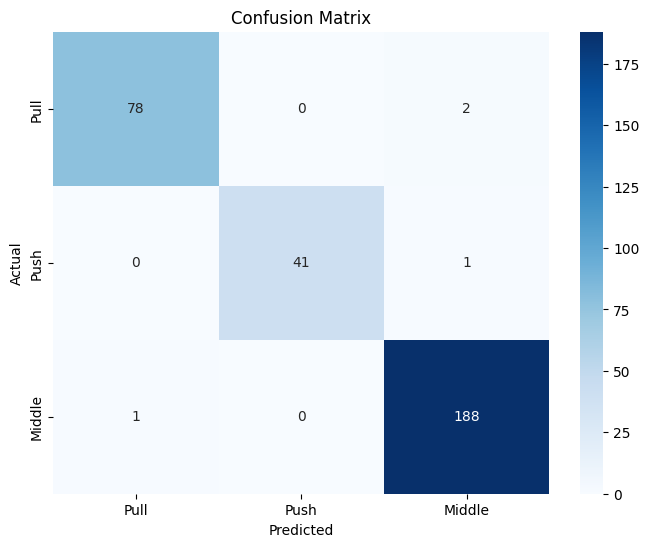

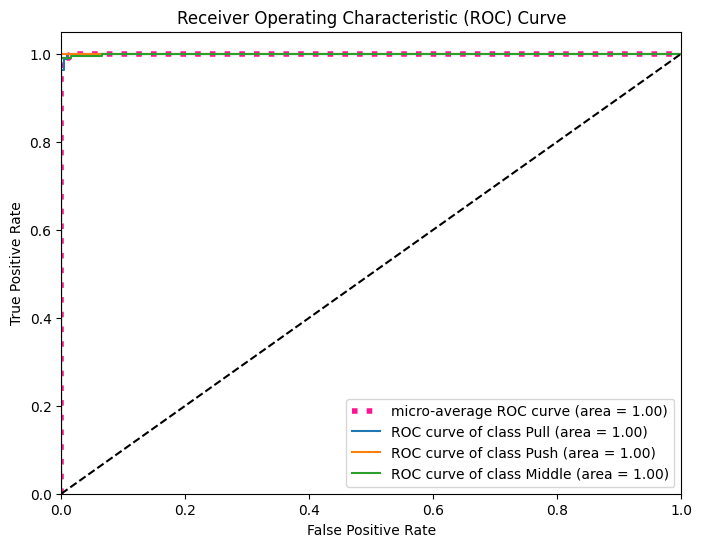

Accuracy: 0.9871
Precision: 0.9872
Recall: 0.9871
F1 Score: 0.9871


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import label_binarize

# 예측 확률 계산
y_scores = XGB_model.predict_proba(X)

# 클래스의 개수를 지정하여 label_binarize 함수 사용
y_binarized = label_binarize(y, classes=[0, 1, 2])  # 클래스 개수에 맞게 설정

# 예측된 클래스
y_pred = XGB_model.predict(X)

# Accuracy, Precision, Recall, F1 Score 계산
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

# Confusion Matrix 계산
cm = confusion_matrix(y, y_pred)

# 혼동 행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 각 클래스에 대한 ROC curve 및 AUC 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_mapping)):
    fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 마이크로 평균 ROC curve 및 AUC 계산
fpr["micro"], tpr["micro"], _ = roc_curve(y_binarized.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

for i, class_name in enumerate(class_mapping.keys()):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
print(y_scores.shape)

(311,)


In [ ]:
# 클래스별 SHAP 분석 및 시각화
for class_name, class_features in class_data.items():
    class_features = np.array(class_features)
    class_X = X[y == class_mapping[class_name]]

    # 특정 관절 인덱스 설정
    wrist_left_idx = feature_names.index('left_wrist_x')
    wrist_right_idx = feature_names.index('right_wrist_x')
    elbow_left_idx = feature_names.index('left_elbow_x')
    elbow_right_idx = feature_names.index('right_elbow_x')
    shoulder_left_idx = feature_names.index('left_shoulder_x')
    shoulder_right_idx = feature_names.index('right_shoulder_x')
    feature_indices = [
        wrist_left_idx, wrist_left_idx + 1, wrist_right_idx, wrist_right_idx + 1,
        elbow_left_idx, elbow_left_idx + 1, elbow_right_idx, elbow_right_idx + 1,
        shoulder_left_idx, shoulder_left_idx + 1, shoulder_right_idx, shoulder_right_idx + 1
    ]

    # 특정 관절만을 가지고 SHAP 값을 다시 계산
    class_X_selected = class_X[:, feature_indices]
    shap_values_class = explainer.shap_values(class_X_selected)

    # SHAP 그래프 생성
    shap.summary_plot(
        shap_values_class, class_X_selected,
        feature_names=feature_names
    )

# **성능평가용 코드**

#FORCE PLOT

In [ ]:
# Pull Force Plot

shap.initjs()
shap.plots.force(explanation[0],
                feature_names=feature_names)


In [ ]:
#Push Force Plot

shap.initjs()
shap.plots.force(explanation[1],
                feature_names=feature_names)


In [ ]:
#Middle Force Plot

shap.initjs()
shap.plots.force(explanation[2],
                feature_names=feature_names)


#DEPENDENCY PLOT

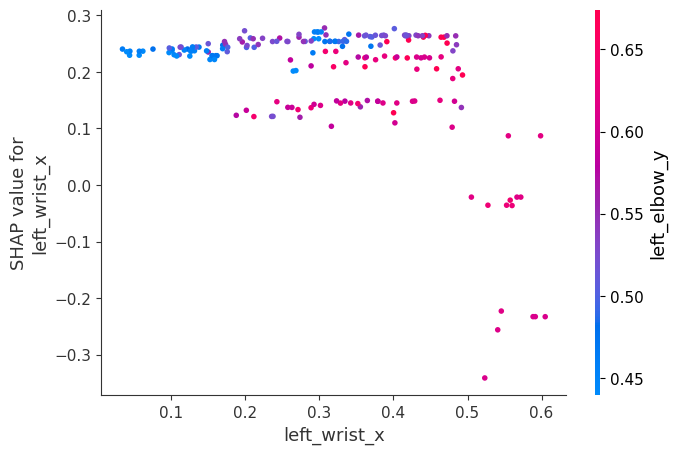

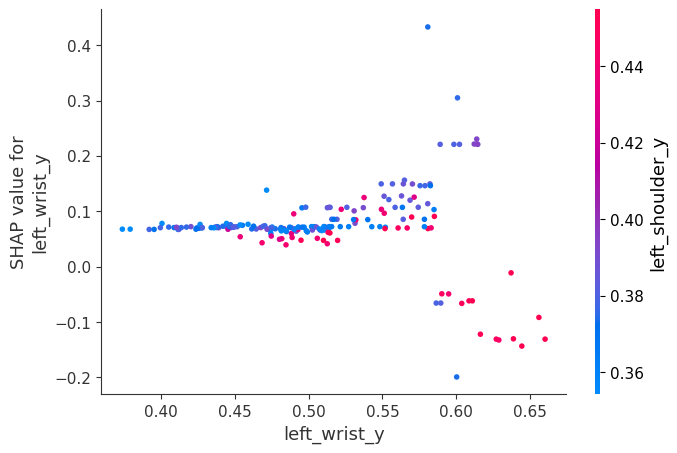

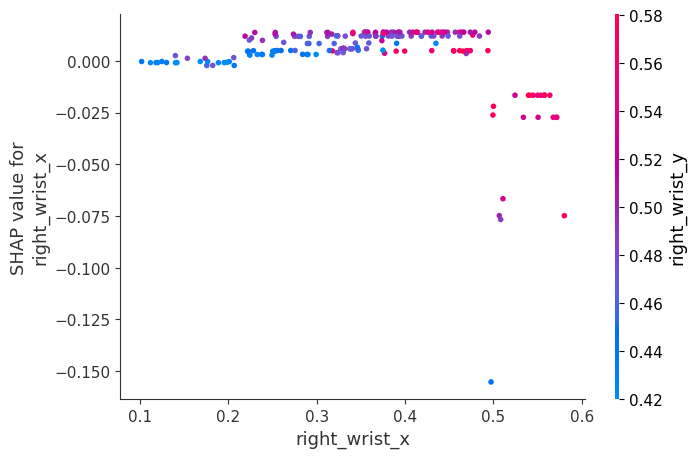

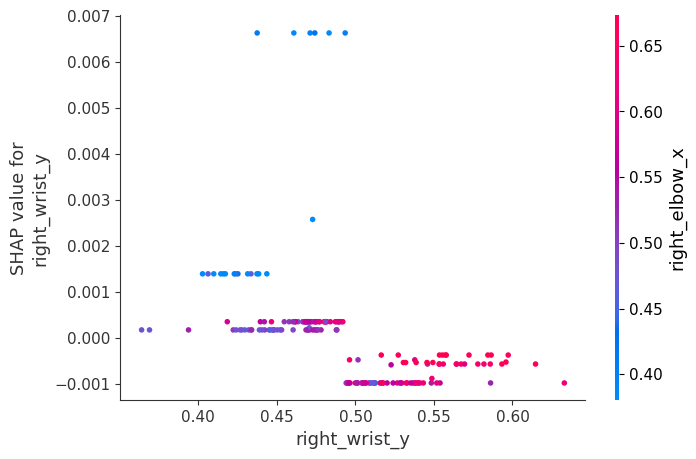

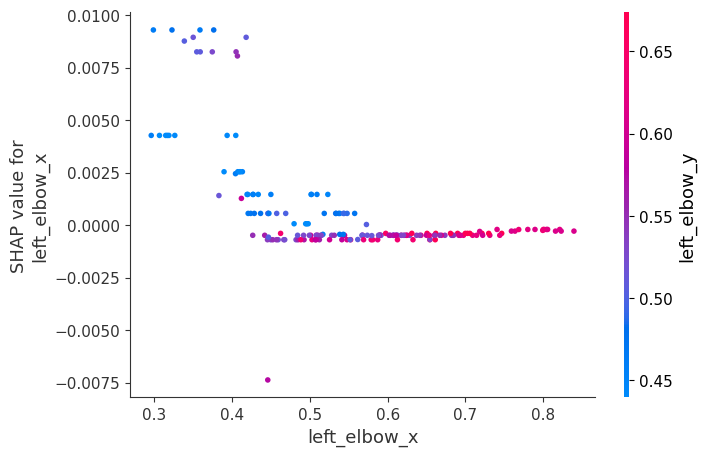

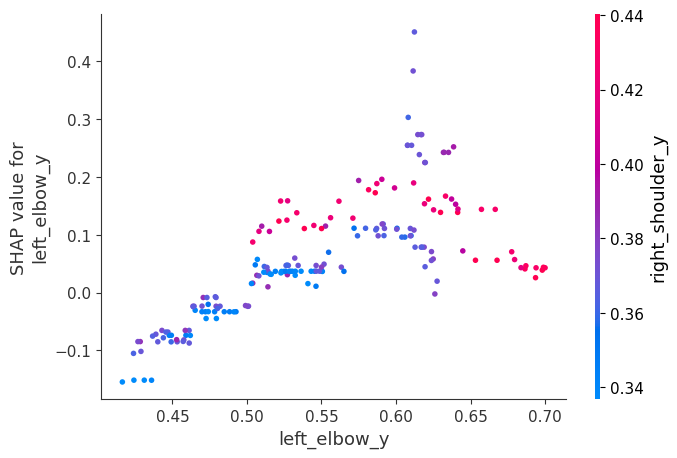

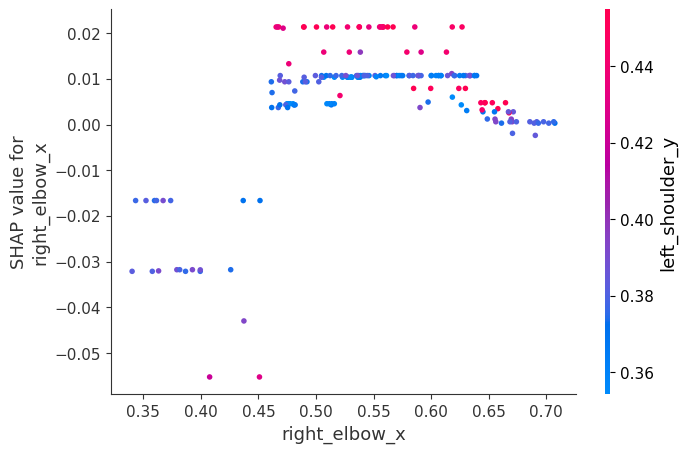

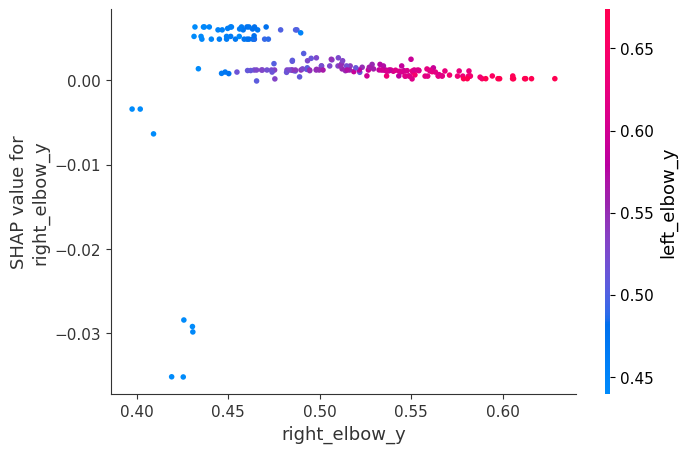

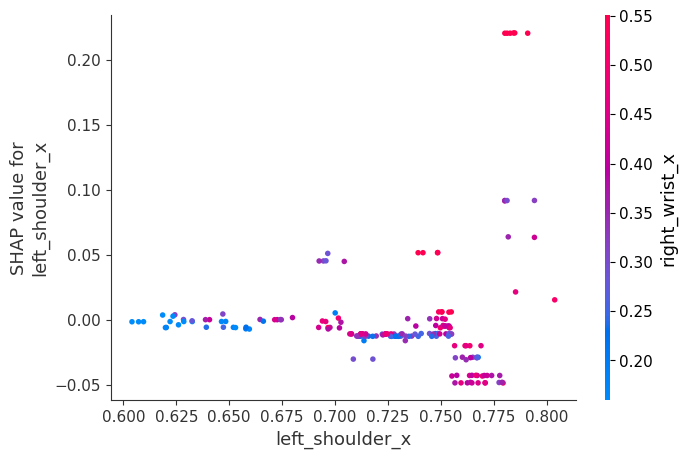

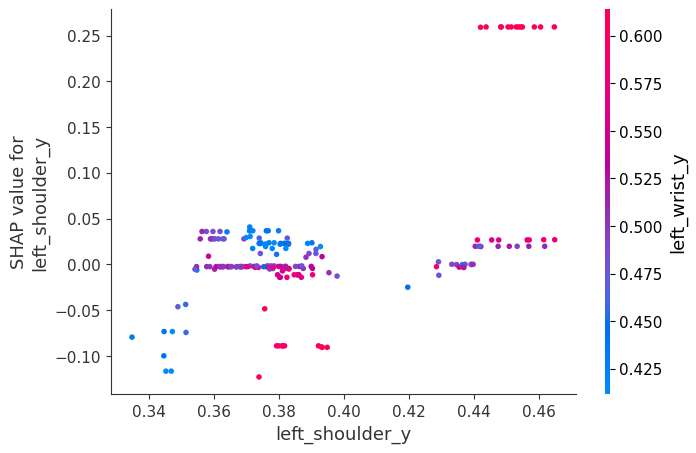

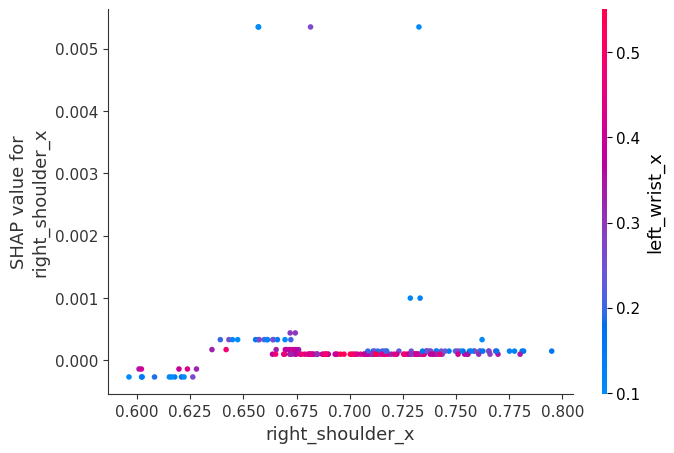

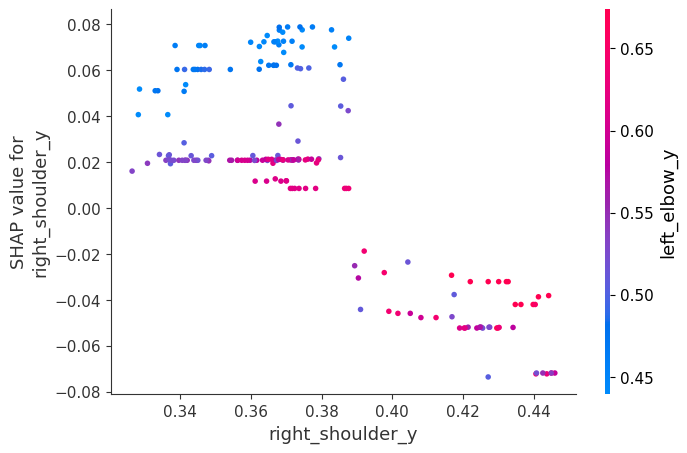

In [ ]:
#Dependency plot

for feature_name in feature_names:
    shap.dependence_plot(feature_name, shap_values_class, class_X_selected,
                         feature_names=feature_names)